# Javier Blanco Cordero
Contact: javierblancordero@gmail.com
## causaLens - Code Test
27/06/2020

# 0. Helpers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import r2_score

from statsmodels.graphics import tsaplots
from statsmodels.tsa._stl import STL
import ephem

In [2]:
# https://rhodesmill.org/pyephem/quick.html#bodies
    
def get_AU_distance_to_moon(date):
    """Returns AU distance to earth-moon given a date"""
    moon = ephem.Moon
    return moon(date).earth_distance
    
def get_AU_distance_to_sun(date):
    """Returns AU distance to earth-sun given a date"""
    sun = ephem.Sun
    return sun(date).earth_distance

In [3]:
def get_phase_on_day(date):
  """Returns a floating-point number from 0-1. where 0=new, 1=full"""
  
  date = ephem.Date(date)
  nnm = ephem.next_new_moon    (date)
  pnm = ephem.previous_new_moon(date)

  lunation=(date-pnm)/(nnm-pnm)

  return (math.sin(math.pi*lunation))

In [4]:
sns.set()
plt.rcParams['figure.figsize'] = (20, 5)
register_matplotlib_converters()

In [5]:
def plot_AC_and_PAC(series, lags):
    fig, (ax1,ax2) = plt.subplots(1, 2)
    
    tsaplots.plot_acf(series, ax=ax1, lags=lags, alpha=.05)
    ax1.set_title('AC '+series.name)
    
    tsaplots.plot_pacf(series, ax=ax2, lags=lags, alpha=.05)
    ax2.set_title('PAC ' +series.name)
    plt.show()

In [6]:
def plot_residuals_distribution(total_residuals, train_residuals, test_residuals, lags):
    plt.plot(train_residuals.index, train_residuals, color='blue', alpha=.75, label='train')
    plt.plot(test_residuals.index, test_residuals, color='red', alpha=.75, label='test')
    plt.title('Residuals evolution', size=15)
    plt.axvline(train_df.index[-1], color='grey', linewidth=4, alpha=.2)
    plt.axvline(test_df.index[-1], color='grey', linewidth=4, alpha=.2)
    plt.legend()
    plt.show()
    
    fig, (ax1,ax2) = plt.subplots(1, 2)
    tsaplots.plot_acf(train_residuals, ax=ax1, lags=lags, alpha=.05, label='train', color='blue')
    tsaplots.plot_acf(test_residuals, ax=ax1, lags=lags, alpha=.05, label='test', color='red')
    ax1.set_title('Residuals Autocorrelation')
    
    ax2.set_title('Residuals Distribution')
    sns.distplot(train_residuals, ax=ax2, label='train', color='blue')
    sns.distplot(test_residuals, ax=ax2, label='test', color='red')
    plt.axvline(0, color='black', linewidth=1)
    
    plt.legend()
    plt.show()

# 1. Import data
### 1.1 Load data

In [7]:
main_df = pd.read_csv('Data/venezia.csv')

display(main_df.head())
main_df.info()

,datetime,level
0,1983-01-01 01:00:00,44.0
1,1983-01-01 02:00:00,35.0
2,1983-01-01 03:00:00,23.0
3,1983-01-01 04:00:00,10.0
4,1983-01-01 05:00:00,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289272 entries, 0 to 289271
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   datetime  289272 non-null  object 
 1   level     289272 non-null  float64
dtypes: float64(1), object(1)
memory usage: 4.4+ MB


In [8]:
date_column = 'datetime'
forecast_column = 'level'

### 2.1 First data checks

In [9]:
# Check available dates and intervals
main_df[date_column].values[:20]

array(['1983-01-01 01:00:00', '1983-01-01 02:00:00',
       '1983-01-01 03:00:00', '1983-01-01 04:00:00',
       '1983-01-01 05:00:00', '1983-01-01 06:00:00',
       '1983-01-01 07:00:00', '1983-01-01 08:00:00',
       '1983-01-01 09:00:00', '1983-01-01 10:00:00',
       '1983-01-01 11:00:00', '1983-01-01 12:00:00',
       '1983-01-01 13:00:00', '1983-01-01 14:00:00',
       '1983-01-01 15:00:00', '1983-01-01 16:00:00',
       '1983-01-01 17:00:00', '1983-01-01 18:00:00',
       '1983-01-01 19:00:00', '1983-01-01 20:00:00'], dtype=object)

In [10]:
# Count nulls
main_df.isna().sum()

datetime    0
level       0
dtype: int64

In [11]:
# Convert date column into datetime format
main_df[date_column] = pd.to_datetime(main_df[date_column], format='%Y-%m-%d %H', errors='coerce') #'%m/%d/%Y'

# Also, create a DateTimeIndex
main_df.index = pd.DatetimeIndex(main_df[date_column])
main_df.index.name = None

# Use to_numeric in case there´s presence of strings
for column in [forecast_column]:
    main_df[column] = pd.to_numeric(main_df[column], errors='coerce')

# Sort data out chronologically
main_df.sort_index(inplace=True)
display(main_df.head())
display(main_df.tail())

,datetime,level
1983-01-01 01:00:00,1983-01-01 01:00:00,44.0
1983-01-01 02:00:00,1983-01-01 02:00:00,35.0
1983-01-01 03:00:00,1983-01-01 03:00:00,23.0
1983-01-01 04:00:00,1983-01-01 04:00:00,10.0
1983-01-01 05:00:00,1983-01-01 05:00:00,1.0


,datetime,level
2015-12-31 20:00:00,2015-12-31 20:00:00,-18.0
2015-12-31 21:00:00,2015-12-31 21:00:00,-14.0
2015-12-31 22:00:00,2015-12-31 22:00:00,-5.0
2015-12-31 23:00:00,2015-12-31 23:00:00,8.0
2016-01-01 00:00:00,2016-01-01 00:00:00,20.0


In [12]:
# Frequency seems hourly
print('dataframe rows: ' + str(len(main_df.index.unique())))

print('hours elapsed: ' + str((main_df.index.max() - main_df.index.min())/pd.Timedelta(hours=1) + 1))

dataframe rows: 289267
hours elapsed: 289272.0


In [13]:
# We seem to have 5 points missing, let's check them

# New index
new_df = pd.DataFrame(
     index = pd.date_range(start=main_df.index.min(), 
                           end=main_df.index.max(), 
                           freq='H') # frecuencies available https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases
 )
main_df = pd.merge(new_df, main_df, how='left', left_index=True, right_index=True)
main_df[date_column] = main_df.index

# Missing values
missing = main_df.loc[main_df[forecast_column].isna()]
display(missing)

,datetime,level
1999-12-31,1999-12-31,NaN
2005-09-07,2005-09-07,NaN
2008-12-31,2008-12-31,NaN
2010-09-07,2010-09-07,NaN
2011-09-07,2011-09-07,NaN


In [14]:
# Filling missing values
main_df[forecast_column] = main_df[forecast_column].interpolate()

# Check they have been filled
main_df.loc[main_df.datetime.isin(list(missing.index))]

,datetime,level
1999-12-31,1999-12-31,18.5
2005-09-07,2005-09-07,49.5
2008-12-31,2008-12-31,26.5
2010-09-07,2010-09-07,36.0
2011-09-07,2011-09-07,-0.5


# 2. EDA

### 2.1 Check time series evolution

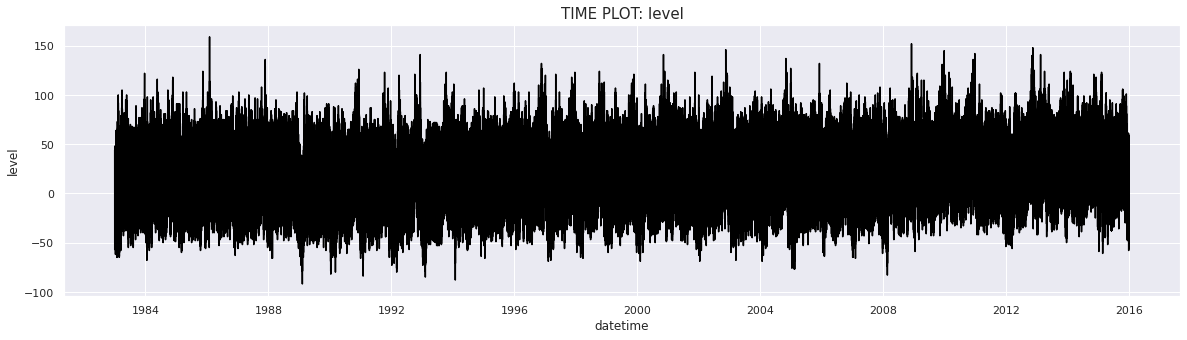

In [15]:
# Time plot: Original 
plt.title('TIME PLOT: '+forecast_column, size=15)
plt.ylabel(forecast_column)
plt.xlabel(date_column)
# plt.plot(ts[date_column], ts[forecast_column], color='black')
plt.plot(main_df[date_column], main_df[forecast_column], color='black')
plt.show()

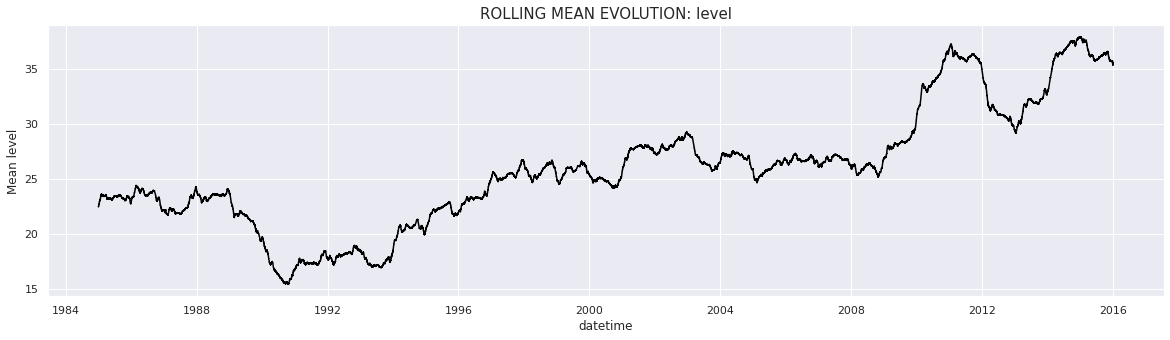

In [16]:
# Mean evolution: original
plt.title('ROLLING MEAN EVOLUTION: '+forecast_column, size=15)
plt.ylabel('Mean '+forecast_column)
plt.xlabel(date_column)
# plt.plot(ts[date_column], ts[forecast_column].rolling(6).mean(), color='black')
plt.plot(main_df[date_column], main_df[forecast_column].rolling(24*365*2).mean(), color='black')
plt.show()

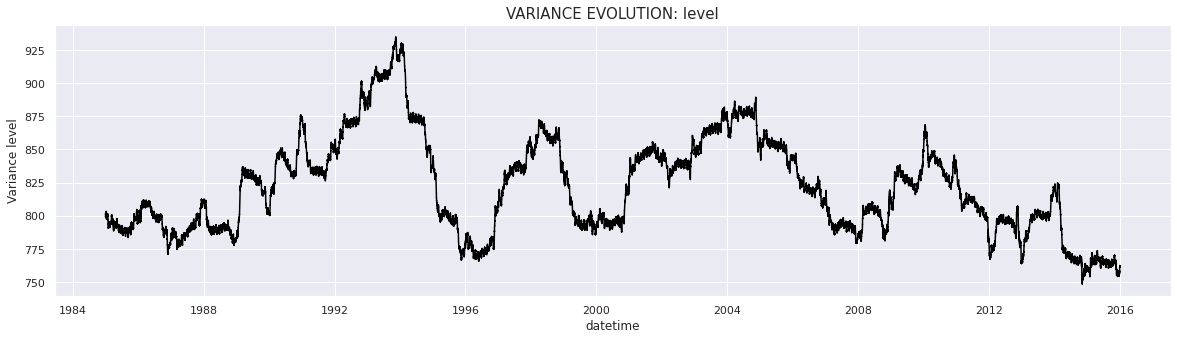

In [17]:
# Variance evolution: original
plt.title('VARIANCE EVOLUTION: '+forecast_column, size=15)
plt.ylabel('Variance '+forecast_column)
plt.xlabel(date_column)
plt.plot(main_df[date_column], main_df[forecast_column].rolling(24*365*2).var(), color='black')
plt.show()

### 2.2 Autocorrelation

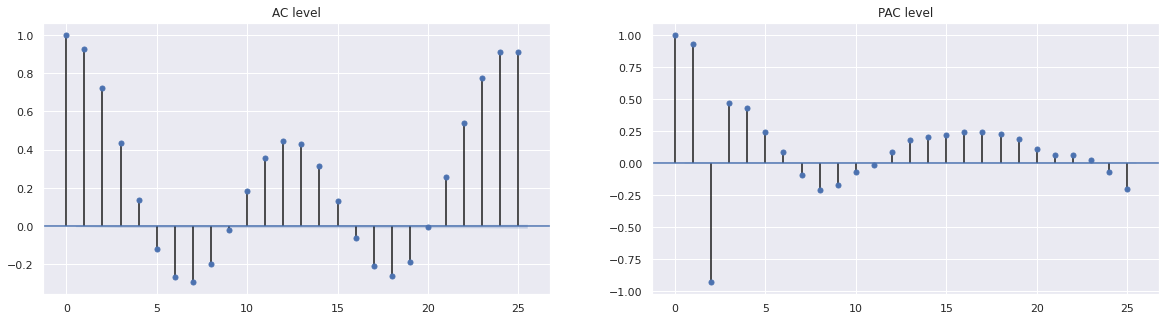

In [18]:
# Autocorrelation and partial autocorrelation for last 25 hours
plot_AC_and_PAC(main_df[forecast_column], lags=25) # Original

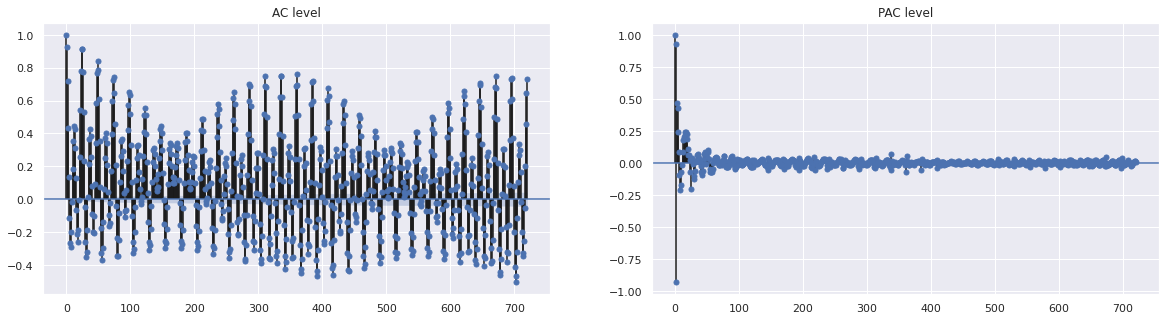

In [19]:
# Autocorrelation and partial autocorrelation for last 29 days
plot_AC_and_PAC(main_df[forecast_column], lags=24*30) # Original

# 3. Data Transformations

In [20]:
main_df['moon_dist'] = [get_AU_distance_to_moon(date) for date in main_df.index]
main_df.head()

,datetime,level,moon_dist
1983-01-01 01:00:00,1983-01-01 01:00:00,44.0,0.002394
1983-01-01 02:00:00,1983-01-01 02:00:00,35.0,0.002395
1983-01-01 03:00:00,1983-01-01 03:00:00,23.0,0.002396
1983-01-01 04:00:00,1983-01-01 04:00:00,10.0,0.002396
1983-01-01 05:00:00,1983-01-01 05:00:00,1.0,0.002397


In [21]:
main_df['sun_dist'] = [get_AU_distance_to_sun(date) for date in main_df.index]
main_df.head()

,datetime,level,moon_dist,sun_dist
1983-01-01 01:00:00,1983-01-01 01:00:00,44.0,0.002394,0.983272
1983-01-01 02:00:00,1983-01-01 02:00:00,35.0,0.002395,0.983271
1983-01-01 03:00:00,1983-01-01 03:00:00,23.0,0.002396,0.983271
1983-01-01 04:00:00,1983-01-01 04:00:00,10.0,0.002396,0.983271
1983-01-01 05:00:00,1983-01-01 05:00:00,1.0,0.002397,0.983270


In [22]:
main_df['moon_phase'] = [get_phase_on_day(date) for date in main_df.index]
main_df.head()

,datetime,level,moon_dist,sun_dist,moon_phase
1983-01-01 01:00:00,1983-01-01 01:00:00,44.0,0.002394,0.983272,0.983233
1983-01-01 02:00:00,1983-01-01 02:00:00,35.0,0.002395,0.983271,0.982423
1983-01-01 03:00:00,1983-01-01 03:00:00,23.0,0.002396,0.983271,0.981594
1983-01-01 04:00:00,1983-01-01 04:00:00,10.0,0.002396,0.983271,0.980747
1983-01-01 05:00:00,1983-01-01 05:00:00,1.0,0.002397,0.983270,0.979880


In [23]:
main_df['sun_acceleration'] = (1.987E+10*6.67E-11)/((1.496E+11*main_df['sun_dist'])**2)
main_df.head()

,datetime,level,moon_dist,sun_dist,moon_phase,sun_acceleration
1983-01-01 01:00:00,1983-01-01 01:00:00,44.0,0.002394,0.983272,0.983233,6.125102e-23
1983-01-01 02:00:00,1983-01-01 02:00:00,35.0,0.002395,0.983271,0.982423,6.125107e-23
1983-01-01 03:00:00,1983-01-01 03:00:00,23.0,0.002396,0.983271,0.981594,6.125112e-23
1983-01-01 04:00:00,1983-01-01 04:00:00,10.0,0.002396,0.983271,0.980747,6.125117e-23
1983-01-01 05:00:00,1983-01-01 05:00:00,1.0,0.002397,0.983270,0.979880,6.125122e-23


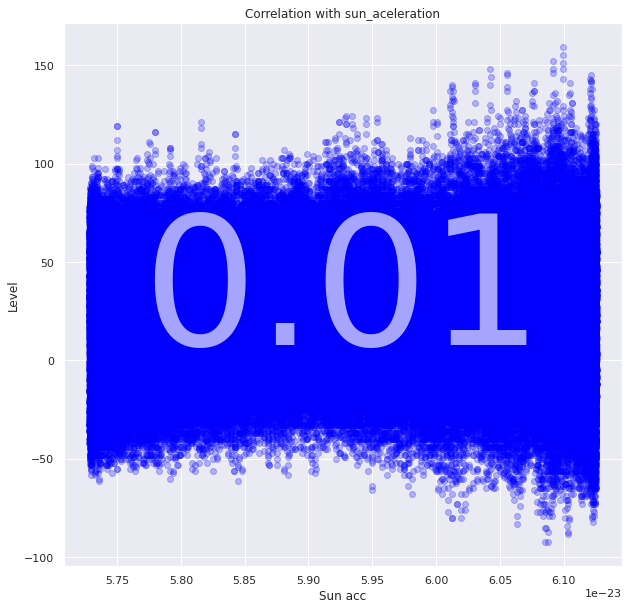

In [24]:
x = main_df['sun_acceleration']
y = main_df['level']
plt.figure(figsize=(10,10))
plt.title('Correlation with sun_aceleration')
plt.scatter(x, y, label='Correlation with sun_aceleration', color='blue', alpha=0.25)
plt.text((x.max() - x.min()) / 2 + x.min(),
         (y.max()-y.min())/2+y.min(),
         str(round(scipy.stats.pearsonr(x, y)[0], 2)),
         verticalalignment='center', horizontalalignment='center', fontsize=180, color='white',
         alpha=0.65)  # coef corr)
plt.xlabel('Sun acc')
plt.ylabel('Level')
plt.show()

In [25]:
hourly_subsidence_rate = 0.1/(365*24) # https://www.nature.com/articles/srep02710 (in cm)
main_df['Venice_relative_subsidence'] = np.linspace(start = 0, stop = len(main_df)*hourly_subsidence_rate, num = len(main_df))
main_df.head()

,datetime,level,moon_dist,sun_dist,moon_phase,sun_acceleration,Venice_relative_subsidence
1983-01-01 01:00:00,1983-01-01 01:00:00,44.0,0.002394,0.983272,0.983233,6.125102e-23,0.000000
1983-01-01 02:00:00,1983-01-01 02:00:00,35.0,0.002395,0.983271,0.982423,6.125107e-23,0.000011
1983-01-01 03:00:00,1983-01-01 03:00:00,23.0,0.002396,0.983271,0.981594,6.125112e-23,0.000023
1983-01-01 04:00:00,1983-01-01 04:00:00,10.0,0.002396,0.983271,0.980747,6.125117e-23,0.000034
1983-01-01 05:00:00,1983-01-01 05:00:00,1.0,0.002397,0.983270,0.979880,6.125122e-23,0.000046


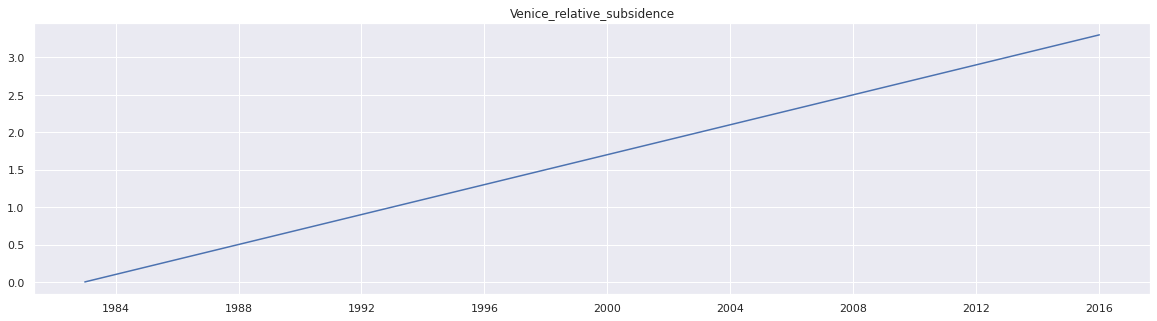

In [26]:
plt.plot(main_df.index, main_df['Venice_relative_subsidence'])
plt.title('Venice_relative_subsidence')
plt.show()

## Sea level

In [54]:
sea_level = pd.read_csv('Data/Venezia/epa-sea-level_csv.csv')

# Convert date column into datetime format
sea_level['Year'] = pd.to_datetime(sea_level['Year'], format='%Y-%m-%d', errors='coerce') #'%m/%d/%Y'

# Also, create a DateTimeIndex
sea_level.index = pd.DatetimeIndex(sea_level['Year'])
sea_level.index.name = None

# Use to_numeric in case there´s presence of strings
for column in ['CSIRO Adjusted Sea Level', 'Lower Error Bound','Upper Error Bound']:
    sea_level[column] = pd.to_numeric(sea_level[column], errors='coerce')

# Sort data out chronologically
sea_level.sort_index(inplace=True)

# Remove last two data points
sea_level = sea_level.iloc[:-2]
display(sea_level.head())
display(sea_level.tail())

,Year,CSIRO Adjusted Sea Level,Lower Error Bound,Upper Error Bound,NOAA Adjusted Sea Level
1880-03-15,1880-03-15,0.000000,-0.952756,0.952756,NaN
1881-03-15,1881-03-15,0.220472,-0.732283,1.173228,NaN
1882-03-15,1882-03-15,-0.440945,-1.346457,0.464567,NaN
1883-03-15,1883-03-15,-0.232283,-1.129921,0.665354,NaN
1884-03-15,1884-03-15,0.590551,-0.283465,1.464567,NaN


,Year,CSIRO Adjusted Sea Level,Lower Error Bound,Upper Error Bound,NOAA Adjusted Sea Level
2008-03-15,2008-03-15,8.350394,8.078740,8.622047,7.907365
2009-03-15,2009-03-15,8.586614,8.311024,8.862205,8.046354
2010-03-15,2010-03-15,8.901575,8.618110,9.185039,8.122973
2011-03-15,2011-03-15,8.964567,8.661417,9.267717,8.053065
2012-03-15,2012-03-15,9.326772,8.992126,9.661417,8.457058


In [55]:
# Usea https://sealevel.nasa.gov/ to fill recent data
last_level = float(sea_level['CSIRO Adjusted Sea Level'][-1])

sea_level_nasa = pd.DataFrame({'Year':[
    pd.to_datetime('2013-03-15', format='%Y-%m-%d %H'), 
    pd.to_datetime('2014-03-15', format='%Y-%m-%d %H'), 
    pd.to_datetime('2015-03-15', format='%Y-%m-%d %H'),
    pd.to_datetime('2016-01-01', format='%Y-%m-%d %H'), 
    pd.to_datetime('2016-03-15', format='%Y-%m-%d %H'), 
    pd.to_datetime('2017-03-15', format='%Y-%m-%d %H'), 
    pd.to_datetime('2018-03-15', format='%Y-%m-%d %H'), 
    pd.to_datetime('2019-03-15', format='%Y-%m-%d %H')],
                              'CSIRO Adjusted Sea Level': [
                                  last_level + 3.3*0.129921*1, 
                                  last_level + 3.3*0.129921*2, 
                                  last_level + 3.3*0.129921*3,
                                  last_level + 3.3*0.129921*(3+9.5/12),
                                  last_level + 3.3*0.129921*4, 
                                  last_level + 3.3*0.129921*5, 
                                  last_level + 3.3*0.129921*6, 
                                  last_level + 3.3*0.129921*7]})

# Also, create a DateTimeIndex
sea_level_nasa.index = pd.DatetimeIndex(sea_level_nasa['Year'])
sea_level_nasa.index.name = None

sea_level_nasa

,Year,CSIRO Adjusted Sea Level
2013-03-15,2013-03-15,9.755511
2014-03-15,2014-03-15,10.184250
2015-03-15,2015-03-15,10.612990
2016-01-01,2016-01-01,10.952408
2016-03-15,2016-03-15,11.041729
2017-03-15,2017-03-15,11.470468
2018-03-15,2018-03-15,11.899207
2019-03-15,2019-03-15,12.327947


,datetime,level,moon_dist,sun_dist,moon_phase,sun_acceleration,Venice_relative_subsidence,CSIRO_adj_sea_level
1983-01-01 01:00:00,1983-01-01 01:00:00,44.0,0.002394,0.983272,0.983233,6.125102e-23,0.000000,1.12
1983-01-01 02:00:00,1983-01-01 02:00:00,35.0,0.002395,0.983271,0.982423,6.125107e-23,0.000011,1.12
1983-01-01 03:00:00,1983-01-01 03:00:00,23.0,0.002396,0.983271,0.981594,6.125112e-23,0.000023,1.12
1983-01-01 04:00:00,1983-01-01 04:00:00,10.0,0.002396,0.983271,0.980747,6.125117e-23,0.000034,1.12
1983-01-01 05:00:00,1983-01-01 05:00:00,1.0,0.002397,0.983270,0.979880,6.125122e-23,0.000046,1.12


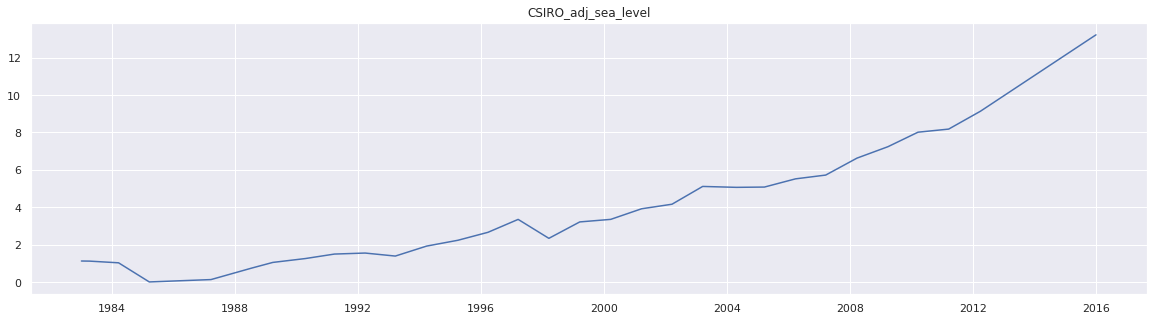

In [56]:
sea_level = sea_level.append(sea_level_nasa)

main_df = pd.merge(main_df, sea_level[['CSIRO Adjusted Sea Level']], 
                   how = 'left',
                   left_index=True, right_index=True)
main_df.columns = list(main_df.columns[:-1]) + ['CSIRO_adj_sea_level']
main_df.head()
main_df['CSIRO_adj_sea_level'] = main_df['CSIRO_adj_sea_level'].interpolate()
main_df['CSIRO_adj_sea_level'] = main_df['CSIRO_adj_sea_level'].fillna(method='bfill')

# inches to cm
main_df['CSIRO_adj_sea_level'] = main_df['CSIRO_adj_sea_level']*2.54
main_df['CSIRO_adj_sea_level'] = main_df['CSIRO_adj_sea_level'] - main_df['CSIRO_adj_sea_level'].min()

display(main_df.head())
plt.plot(main_df.index, main_df['CSIRO_adj_sea_level'])
plt.title('CSIRO_adj_sea_level')
plt.show()

### Adjusted target

In [57]:
main_df['adj_level'] = main_df['level'] - main_df['Venice_relative_subsidence'] - main_df['CSIRO_adj_sea_level']

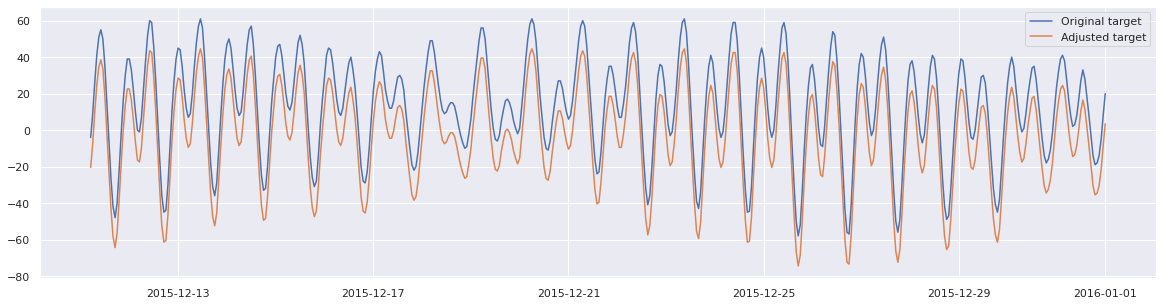

In [58]:
zoom = 500
plt.plot(main_df.index[-zoom:], main_df['level'][-zoom:], label='Original target')
plt.plot(main_df.index[-zoom:], main_df['adj_level'][-zoom:], label='Adjusted target')
plt.legend()
plt.show()

# 4. Save dataframe

In [59]:
#main_df.drop('Unnamed: 0', axis=1, inplace=True)

In [60]:
main_df.to_csv('Data/venezia_transformed.csv',index = False)